In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)

df = pd.read_csv('dataset2.csv')

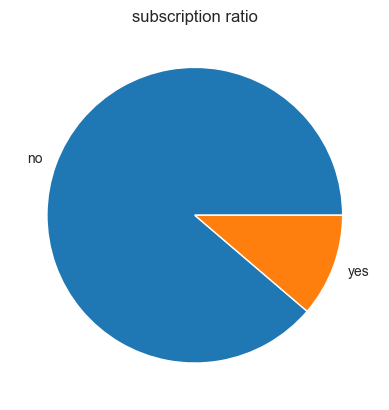

In [68]:
y_counts = df.y.value_counts()
plt.pie(y_counts.values, labels=y_counts.index)
plt.title('subscription ratio');

In [69]:
y_counts

y
no     39487
yes     5011
Name: count, dtype: int64

### Using Random Forests without any resampling

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9082022471910113
Classification Report:
              precision    recall  f1-score   support

          no       0.93      0.97      0.95      7898
         yes       0.65      0.39      0.49      1002

    accuracy                           0.91      8900
   macro avg       0.79      0.68      0.72      8900
weighted avg       0.90      0.91      0.90      8900



### Using Random Forests with 'SMOTE'

In [92]:
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=54)
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8930337078651686
Classification Report:
              precision    recall  f1-score   support

          no       0.96      0.92      0.94      7898
         yes       0.52      0.66      0.58      1002

    accuracy                           0.89      8900
   macro avg       0.74      0.79      0.76      8900
weighted avg       0.91      0.89      0.90      8900



## Optimizing the model

### 1. Identifying overfitting

#### 1) train vs. test accuracy

In [79]:
# Evaluate performance on training set
y_train_pred = rf_classifier.predict(X_train_smote)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
train_report = classification_report(y_train_smote, y_train_pred, output_dict=True)

# Evaluate performance on test set
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, output_dict=True)


print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", train_report)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)

Training Accuracy: 1.0
Training Classification Report:
 {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31589.0}, 'yes': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31589.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 63178.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 63178.0}}
Test Accuracy: 0.8930337078651686
Test Classification Report:
 {'no': {'precision': 0.9557742782152231, 'recall': 0.9221321853633832, 'f1-score': 0.9386518881299136, 'support': 7898.0}, 'yes': {'precision': 0.51953125, 'recall': 0.6636726546906188, 'f1-score': 0.5828220858895705, 'support': 1002.0}, 'accuracy': 0.8930337078651686, 'macro avg': {'precision': 0.7376527641076116, 'recall': 0.792902420027001, 'f1-score': 0.760736987009742, 'support': 8900.0}, 'weighted avg': {'precision': 0.9066601754880711, 'recall': 0.8930337078651686, 'f1-score': 0.8985910497203828, 'support': 8900.0}}


#### 2) cross validation scores

In [85]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import numpy as np

X = df.drop(columns=['y'])
y = df['y']

# Initialize Random Forest and SMOTE
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=54)
smote = SMOTE(random_state=54)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

# List to store CV scores
cv_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    # Evaluate on the test set (not resampled)
    accuracy = rf_classifier.score(X_test, y_test)
    cv_scores.append(accuracy)

# Convert to numpy array for easier calculation
cv_scores = np.array(cv_scores)

# Output results
print("Stratified CV Scores:", cv_scores)
print("Mean Stratified CV Accuracy:", cv_scores.mean())


Stratified CV Scores: [0.89370787 0.89179775 0.89606742 0.89953927 0.89549388]
Mean Stratified CV Accuracy: 0.8953212366999953


In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

X = df.drop(columns=['y'])
y = df['y']

# Initialize Random Forest and SMOTE
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=54)
smote = SMOTE(random_state=54)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

# List to store CV scores
f1_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate the F1-Score for the minority class ('yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')  # Use the 'yes' class for minority
    f1_scores.append(f1)

# Convert to numpy array for easier calculation
f1_scores = np.array(f1_scores)

# Output results
print("Stratified CV F1 Scores for 'yes' class:", f1_scores)
print("Mean Stratified CV F1 Score for 'yes' class:", f1_scores.mean())


Stratified CV F1 Scores for 'yes' class: [0.59661311 0.57604895 0.58844444 0.60632689 0.58488889]
Mean Stratified CV F1 Score for 'yes' class: 0.5904644573984321


In [86]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

X = df.drop(columns=['y'])
y = df['y']

# Initialize Random Forest and SMOTE
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=54)
smote = SMOTE(random_state=54)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

# List to store CV scores
f1_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate the F1-Score for the minority class ('yes')
    f1 = f1_score(y_test, y_pred, pos_label='no')  # Use the 'yes' class for minority
    f1_scores.append(f1)

# Convert to numpy array for easier calculation
f1_scores = np.array(f1_scores)

# Output results
print("Stratified CV F1 Scores for 'no' class:", f1_scores)
print("Mean Stratified CV F1 Score for 'no' class:", f1_scores.mean())


Stratified CV F1 Scores for 'no' class: [0.94005291 0.93746777 0.94045016 0.94227548 0.93992797]
Mean Stratified CV F1 Score for 'no' class: 0.9400348572208952


#### 3) Learning Curve Analysis

In [93]:
import pandas as pd
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(importance_df)


      Feature  Importance
9    duration    0.367467
14     lcdays    0.127245
10   campaign    0.101499
5     balance    0.083813
0         age    0.066809
8     contact    0.042492
12   previous    0.039943
6     housing    0.034147
1         job    0.031852
11      pdays    0.031224
13   poutcome    0.028126
3   education    0.018062
2     marital    0.014747
7        loan    0.011410
4     default    0.001165


In [118]:
df = pd.read_csv('dataset2.csv')
df['y'].value_counts()

y
no     39487
yes     5011
Name: count, dtype: int64

In [123]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'lcdays'],
      dtype='object')

In [124]:
df = df.drop(columns=['marital', 'loan', 'education', 'default', 'poutcome'])

In [127]:
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=54, class_weight='balanced')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8908988764044944
Classification Report:
              precision    recall  f1-score   support

          no       0.96      0.92      0.94      7898
         yes       0.51      0.67      0.58      1002

    accuracy                           0.89      8900
   macro avg       0.73      0.79      0.76      8900
weighted avg       0.91      0.89      0.90      8900



In [128]:
# Evaluate performance on training set
y_train_pred = rf_classifier.predict(X_train_smote)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
train_report = classification_report(y_train_smote, y_train_pred, output_dict=True)

# Evaluate performance on test set
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, output_dict=True)


print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", train_report)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)

Training Accuracy: 1.0
Training Classification Report:
 {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31589.0}, 'yes': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31589.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 63178.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 63178.0}}
Test Accuracy: 0.8908988764044944
Test Classification Report:
 {'no': {'precision': 0.9565045472518782, 'recall': 0.918840212712079, 'f1-score': 0.937294155634485, 'support': 7898.0}, 'yes': {'precision': 0.5118050266565118, 'recall': 0.6706586826347305, 'f1-score': 0.5805615550755939, 'support': 1002.0}, 'accuracy': 0.8908988764044944, 'macro avg': {'precision': 0.734154786954195, 'recall': 0.7947494476734047, 'f1-score': 0.7589278553550395, 'support': 8900.0}, 'weighted avg': {'precision': 0.9064383765061975, 'recall': 0.8908988764044944, 'f1-score': 0.8971316763356076, 'support': 8900.0

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import numpy as np

X = df.drop(columns=['y'])
y = df['y']

# Initialize Random Forest and SMOTE
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=54)
smote = SMOTE(random_state=54)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

# List to store CV scores
cv_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    # Evaluate on the test set (not resampled)
    accuracy = rf_classifier.score(X_test, y_test)
    cv_scores.append(accuracy)

# Convert to numpy array for easier calculation
cv_scores = np.array(cv_scores)

# Output results
print("Stratified CV Scores:", cv_scores)
print("Mean Stratified CV Accuracy:", cv_scores.mean())


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

X = df.drop(columns=['y'])
y = df['y']

# Initialize Random Forest and SMOTE
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=54)
smote = SMOTE(random_state=54)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

# List to store CV scores
f1_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate the F1-Score for the minority class ('yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')  # Use the 'yes' class for minority
    f1_scores.append(f1)

# Convert to numpy array for easier calculation
f1_scores = np.array(f1_scores)

# Output results
print("Stratified CV F1 Scores for 'yes' class:", f1_scores)
print("Mean Stratified CV F1 Score for 'yes' class:", f1_scores.mean())


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

X = df.drop(columns=['y'])
y = df['y']

# Initialize Random Forest and SMOTE
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=54)
smote = SMOTE(random_state=54)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

# List to store CV scores
f1_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled training data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate the F1-Score for the minority class ('yes')
    f1 = f1_score(y_test, y_pred, pos_label='no')  # Use the 'yes' class for minority
    f1_scores.append(f1)

# Convert to numpy array for easier calculation
f1_scores = np.array(f1_scores)

# Output results
print("Stratified CV F1 Scores for 'no' class:", f1_scores)
print("Mean Stratified CV F1 Score for 'no' class:", f1_scores.mean())
